# Import Libraries

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet

# 1.0 Data Understanding and Exploratory Data Analysis (EDA)
# 1.1 Load Dataset 

In [120]:
# Load dataset
df = pd.read_csv('video_games_sales.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)


# Display first five rows
df.head()


,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
Month,,,,,,,
2002-01-01,Sports,108592,2002,1,Xbox,1,0
2002-02-01,RPG,129387,2002,4,Nintendo,0,0
2002-03-01,Sports,114777,2002,4,PC,0,0
2002-04-01,Sports,71738,2002,0,Nintendo,0,0
2002-05-01,Simulation,142512,2002,2,PlayStation,0,0


# 1.2 Dataset Summary

In [121]:
# Check dataset shape
print(f"The Dataset shape is: {df.shape}")

print("----------------------------------")

# Dataset info
df.info()

The Dataset shape is: (264, 7)
----------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2002-01-01 to 2023-12-01
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category       264 non-null    object
 1   Monthly Sales  264 non-null    int64 
 2   Year           264 non-null    int64 
 3   DayOfWeek      264 non-null    int64 
 4   Platform       264 non-null    object
 5   Holiday        264 non-null    int64 
 6   Promotion      264 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 16.5+ KB


In [122]:
# Check for missing values and percentage of missing values
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)

# Combine the results into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Value Description:")
print(missing_summary)

Missing Value Description:
               Missing Values  Percentage
Category                    0         0.0
Monthly Sales               0         0.0
Year                        0         0.0
DayOfWeek                   0         0.0
Platform                    0         0.0
Holiday                     0         0.0
Promotion                   0         0.0


In [123]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

print("---------------------------------------")

# Check unique values
print(f"Unique values:\n{df.nunique()}")

The dataset contains 0 duplicate rows that need to be removed.
---------------------------------------
Unique values:
Category           5
Monthly Sales    264
Year              22
DayOfWeek          7
Platform           4
Holiday            2
Promotion          2
dtype: int64


In [124]:
# Check unique values for categorical features
print("Unique Values in Categorical Features:")
print("---------------------------------------")
print(f"1. Category: {df['Category'].unique()}")
print("---------------------------------------")
print(f"2. Platform: {df['Platform'].unique()}")
print("---------------------------------------")
print(f"3. Holiday: {df['Holiday'].unique()}")
print("---------------------------------------")
print(f"4. Promotion: {df['Promotion'].unique()}")
print("---------------------------------------")
print(f"5. Year: {df['Year'].unique()}")

Unique Values in Categorical Features:
---------------------------------------
1. Category: ['Sports' 'RPG' 'Simulation' 'FPS' 'Adventure']
---------------------------------------
2. Platform: ['Xbox' 'Nintendo' 'PC' 'PlayStation']
---------------------------------------
3. Holiday: [1 0]
---------------------------------------
4. Promotion: [0 1]
---------------------------------------
5. Year: [2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022 2023]


# 1.3 Statistical Analysis

In [125]:
# Summary statistics
df.describe(include='all').round(2)

,Category,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
count,264,264.00,264.00,264.00,264,264.00,264.0
unique,5,NaN,NaN,NaN,4,NaN,NaN
top,Sports,NaN,NaN,NaN,Xbox,NaN,NaN
freq,59,NaN,NaN,NaN,76,NaN,NaN
mean,NaN,112349.00,2012.50,3.01,NaN,0.17,0.2
std,NaN,34144.61,6.36,2.00,NaN,0.37,0.4
min,NaN,10469.00,2002.00,0.00,NaN,0.00,0.0
25%,NaN,88873.75,2007.00,1.00,NaN,0.00,0.0
50%,NaN,112947.50,2012.50,3.00,NaN,0.00,0.0
75%,NaN,135193.50,2018.00,5.00,NaN,0.00,0.0


# EDA

In [126]:
# Get minimum and maximum year and month
min_date = df.index.min()
max_date = df.index.max()
print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")


Minimum date: 2002-01-01 00:00:00
Maximum date: 2023-12-01 00:00:00


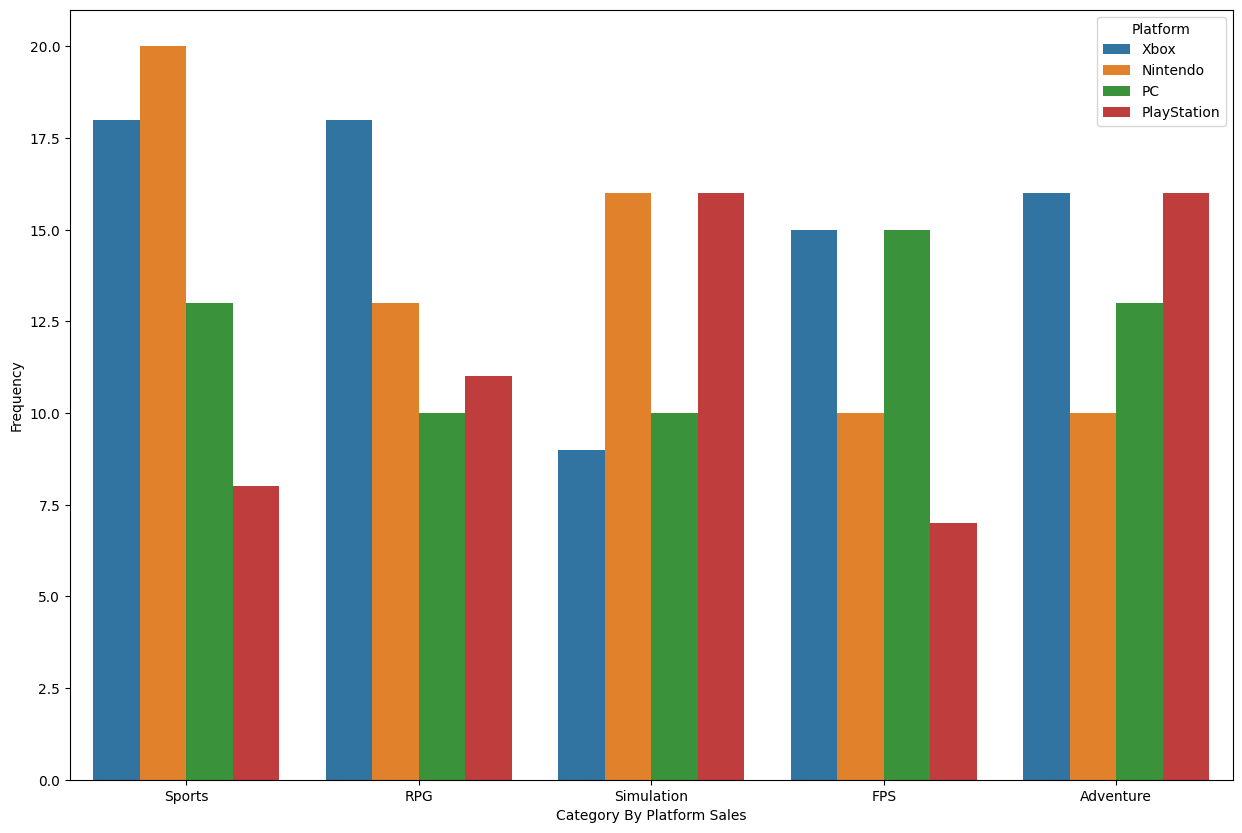

In [127]:
# Category by Year Sales
plt.figure(figsize=(15,10))

sns.countplot(data = df, x = 'Category', hue = 'Platform')

plt.xlabel("Category By Platform Sales")
plt.ylabel("Frequency")
plt.show()

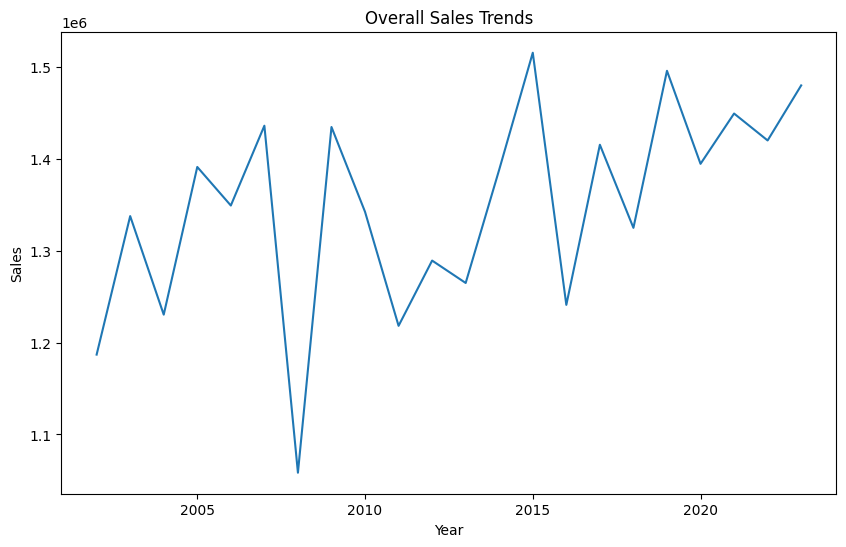

In [128]:

# Aggregate data for time series analysis
monthly_sales = df['Monthly Sales']

# Overall sales trends
df.groupby('Year')['Monthly Sales'].sum().plot(title="Overall Sales Trends", xlabel="Year", ylabel="Sales", figsize=(10, 6))
plt.show()

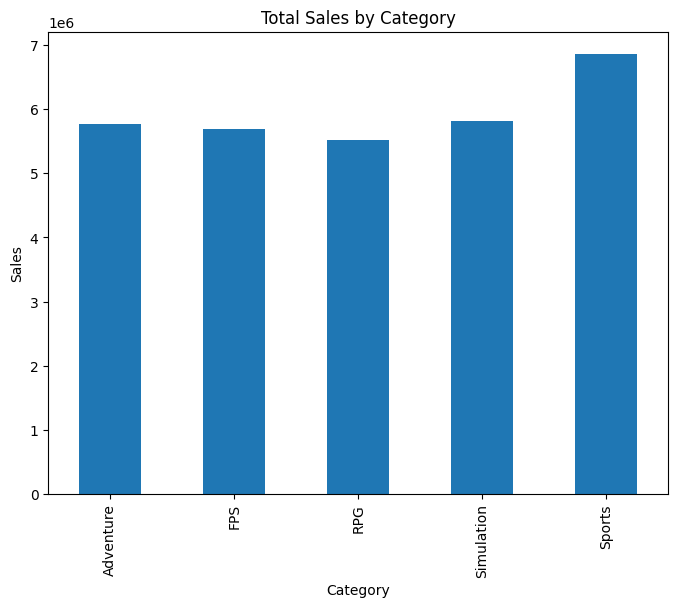

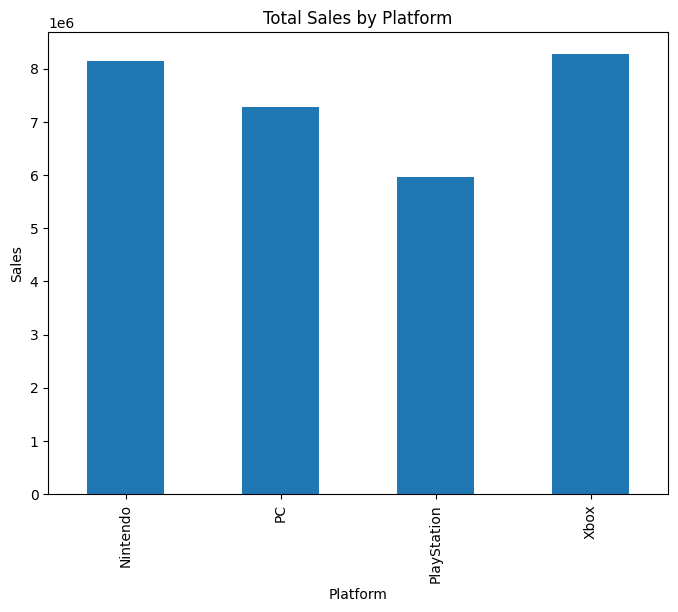

In [129]:
# Sales by Category and Platform
category_sales = df.groupby('Category')['Monthly Sales'].sum()
platform_sales = df.groupby('Platform')['Monthly Sales'].sum()

# Bar charts for sales by category and platform
category_sales.plot(kind='bar', title='Total Sales by Category', xlabel='Category', ylabel='Sales', figsize=(8, 6))
plt.show()

platform_sales.plot(kind='bar', title='Total Sales by Platform', xlabel='Platform', ylabel='Sales', figsize=(8, 6))
plt.show()

In [130]:
# Impact of Holidays and Promotions
holiday_sales = df[df['Holiday'] == 1]['Monthly Sales'].mean()
promotion_sales = df[df['Promotion'] == 1]['Monthly Sales'].mean()
print(f"Average sales during holidays: {holiday_sales}")
print(f"Average sales during promotions: {promotion_sales}")

Average sales during holidays: 114933.54545454546
Average sales during promotions: 113723.29629629629


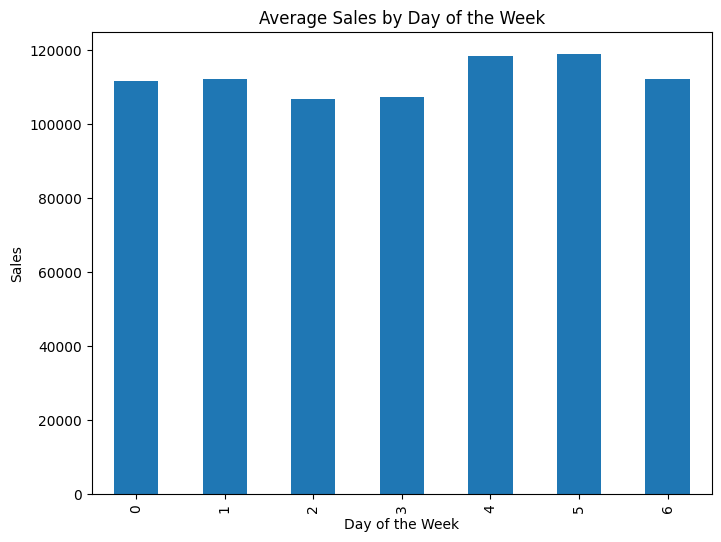

In [131]:
# Sales by day of the week
dow_sales = df.groupby('DayOfWeek')['Monthly Sales'].mean()
dow_sales.plot(kind='bar', title='Average Sales by Day of the Week', xlabel='Day of the Week', ylabel='Sales', figsize=(8, 6))
plt.show()

# Check the Stationality and Seasonality of the Data
 Mathods
 1. Visual Inspection
 2. Global vs Local Check
 3. ADG(Augmented Dickney Fuller) Test -Statistical Tests
 4. KPPS Test - Statistical Tests
 
 # Time Series Models
 1. Auto-Regression Model
 2. MA (Moving Average) Model
 3. ARMA( Auto Regression Moving Average) 
 4. ARIMA ( Auto Regression  Integrated Moving Average)) - almost  the same as ARMA, just does only one simple operation of convering non-stationary series to stationary series before
 5. ETS
 5. RNN
 5. LSTM

 # ACF  AND PACF Plots : measure the corellation between current time periods and previous time lags
**Correlation** is an indicator of relationship between 2 variables
**Auto-correlation**: Relationship of a variable with itd previous time period values(lags). Used Perason Corellation Co-efficient [-1.1]

**Auto-correlation Function**: Direct  and indirect effect of values in previous time lags on current value. Used to find order on MA Model
**Partial Auto-correlation Function**: Only direct effect of values in previous time lags on current value. Used to find order on Auto-Regression Model

# Step 2: Stationarity and Seasonality Checks


# ADF Test

In [132]:
# ADF Test
adf_result = adfuller(monthly_sales)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] <= 0.05:
    print("The data is stationary based on the ADF test.")
else:
    print("The data is not stationary based on the ADF test.")

ADF Statistic: -4.471046070251252
p-value: 0.00022173509005269144
The data is stationary based on the ADF test.


# KPSS Test

In [133]:
# KPSS Test
def kpss_test(series):
    kpss_stat, p_value, _, _ = kpss(series, regression='c')
    print('KPSS Statistic:', kpss_stat)
    print('p-value:', p_value)
    if p_value < 0.05:
        print("The data is not stationary based on the KPSS test.")
    else:
        print("The data is stationary based on the KPSS test.")

kpss_test(monthly_sales)

KPSS Statistic: 0.2905412089601993
p-value: 0.1
The data is stationary based on the KPSS test.


C:\Users\Kenny Ogundana\AppData\Local\Temp\ipykernel_7764\4287641661.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




# Seasonal decomposition

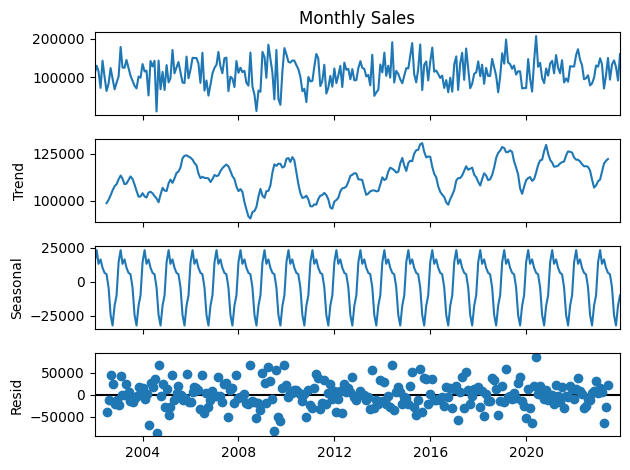

In [134]:
# Seasonal decomposition
result = seasonal_decompose(monthly_sales, model='additive', period=12)
result.plot()
plt.show()

# ACF and PACF plots

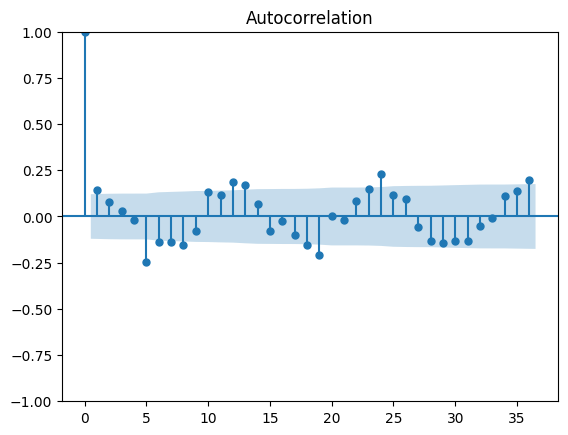

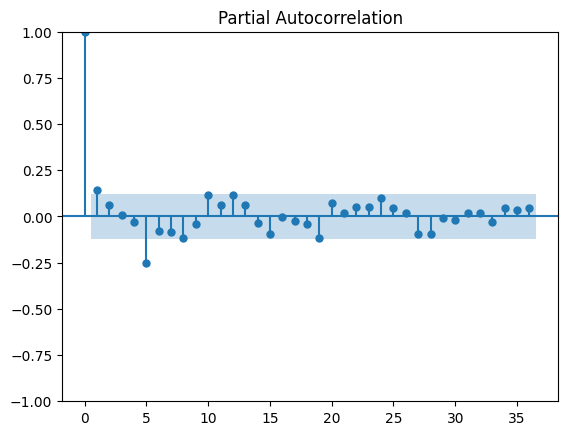

In [135]:
# ACF and PACF plots
plot_acf(monthly_sales, lags=36)
plt.show()
plot_pacf(monthly_sales, lags=36)
plt.show()

 # Step 3: Build Models

In [136]:

# Splitting data into train and test sets
train = monthly_sales[:-4]
test = monthly_sales[-4:]

In [137]:
# ARIMA model
model_arima = ARIMA(train, order=(2, 1, 2))  # Example order, adjust based on ACF/PACF
results_arima = model_arima.fit()
print(results_arima.summary())


c:\Users\Kenny Ogundana\Downloads\video_game_forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\Kenny Ogundana\Downloads\video_game_forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\Kenny Ogundana\Downloads\video_game_forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\Kenny Ogundana\Downloads\video_game_forecast\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Kenny Ogundana\Downloads\video_game_forecast\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-inve

                               SARIMAX Results                                
Dep. Variable:          Monthly Sales   No. Observations:                  260
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3073.473
Date:                Thu, 12 Dec 2024   AIC                           6156.945
Time:                        21:09:22   BIC                           6174.729
Sample:                    01-01-2002   HQIC                          6164.096
                         - 08-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7722      0.113     -6.850      0.000      -0.993      -0.551
ar.L2          0.1844      0.077      2.386      0.017       0.033       0.336
ma.L1         -0.0577      0.086     -0.669      0.5

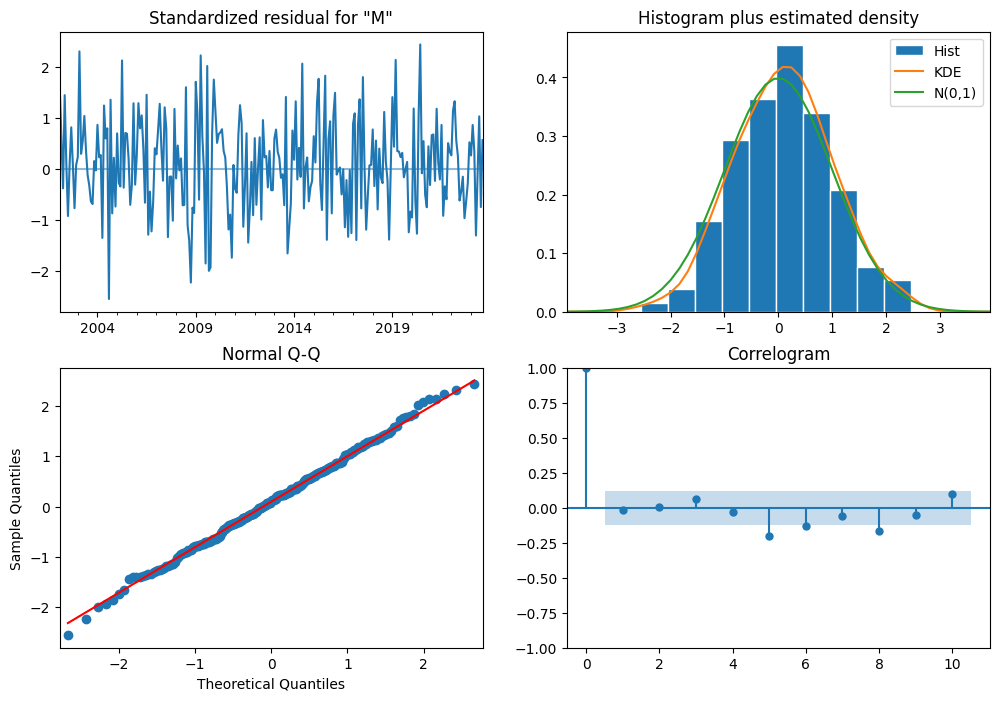

In [138]:
# Plot diagnostics
results_arima.plot_diagnostics(figsize=(12, 8))
plt.show()

In [139]:
# Forecast with ARIMA
forecast_arima = results_arima.forecast(steps=4)

In [140]:
# ETS (Exponential Smoothing)
model_ets = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit()
forecast_ets = model_ets.forecast(steps=4)

c:\Users\Kenny Ogundana\Downloads\video_game_forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\Kenny Ogundana\Downloads\video_game_forecast\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [141]:
# FB Prophet
prophet_data = df.reset_index()[['Month', 'Monthly Sales']]
prophet_data.columns = ['ds', 'y']
model_prophet = Prophet()
model_prophet.fit(prophet_data)


21:09:23 - cmdstanpy - INFO - Chain [1] start processing
21:09:24 - cmdstanpy - INFO - Chain [1] done processing


In [142]:
# Future dataframe for Prophet
future_dates = model_prophet.make_future_dataframe(periods=4, freq='MS')
forecast_prophet = model_prophet.predict(future_dates)

# Step 4: Evaluate Models

In [143]:
# Calculate RMSE for ARIMA
rmse_arima = sqrt(mean_squared_error(test, forecast_arima))
print(f"ARIMA RMSE: {rmse_arima}")

ARIMA RMSE: 28417.864686500296


In [144]:
# Calculate RMSE for ETS
rmse_ets = sqrt(mean_squared_error(test, forecast_ets))
print(f"ETS RMSE: {rmse_ets}")

ETS RMSE: 42299.896741645396


In [145]:
# FB Prophet RMSE
forecast_prophet_test = forecast_prophet.iloc[-8:-4]['yhat']
rmse_prophet = sqrt(mean_squared_error(test, forecast_prophet_test))
print(f"FB Prophet RMSE: {rmse_prophet}")

FB Prophet RMSE: 33386.68580000147


In [146]:
# Compare models
if rmse_arima < rmse_ets and rmse_arima < rmse_prophet:
    print("ARIMA is the best model.")
    final_forecast = forecast_arima
elif rmse_ets < rmse_arima and rmse_ets < rmse_prophet:
    print("ETS is the best model.")
    final_forecast = forecast_ets
else:
    print("FB Prophet is the best model.")
    final_forecast = forecast_prophet.iloc[-4:]['yhat']

ARIMA is the best model.


# Step 5: Final Forecast

In [147]:
# Step 5: Final Forecast
print("Forecast for the next 4 months:")
print(final_forecast)

Forecast for the next 4 months:
2023-09-01    116317.281337
2023-10-01    116682.887806
2023-11-01    113380.772513
2023-12-01    115998.181700
Freq: MS, Name: predicted_mean, dtype: float64


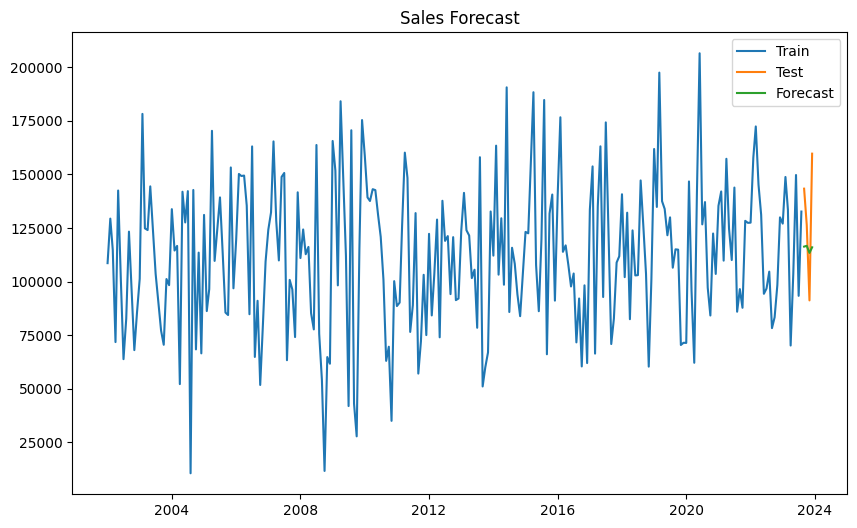

In [148]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(final_forecast, label='Forecast')
plt.legend(loc='best')
plt.title('Sales Forecast')
plt.show()

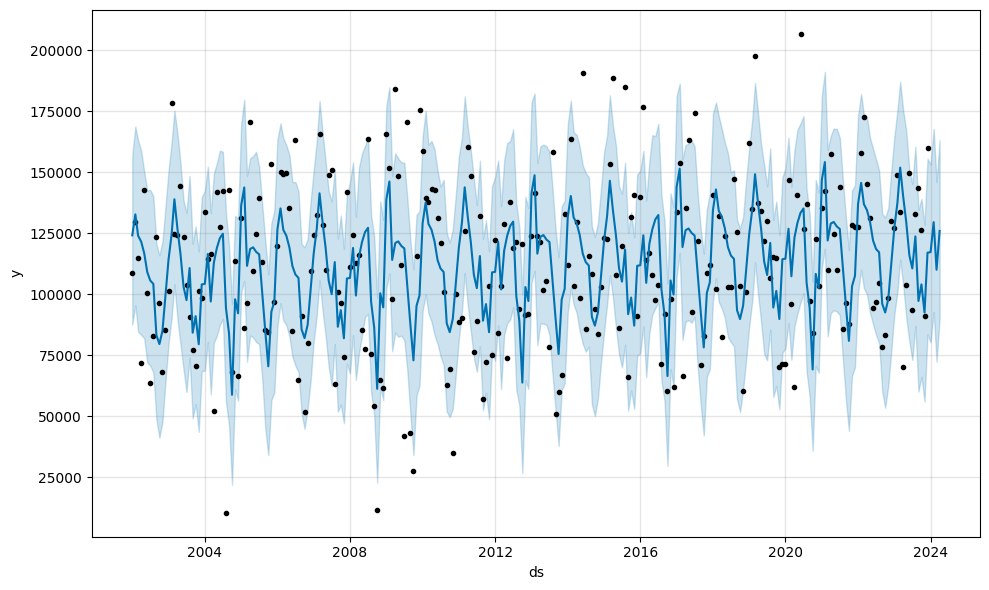

In [149]:
import matplotlib.pyplot as plt

# Plot the forecast using Matplotlib
fig = model_prophet.plot(forecast_prophet_plot)
plt.show()


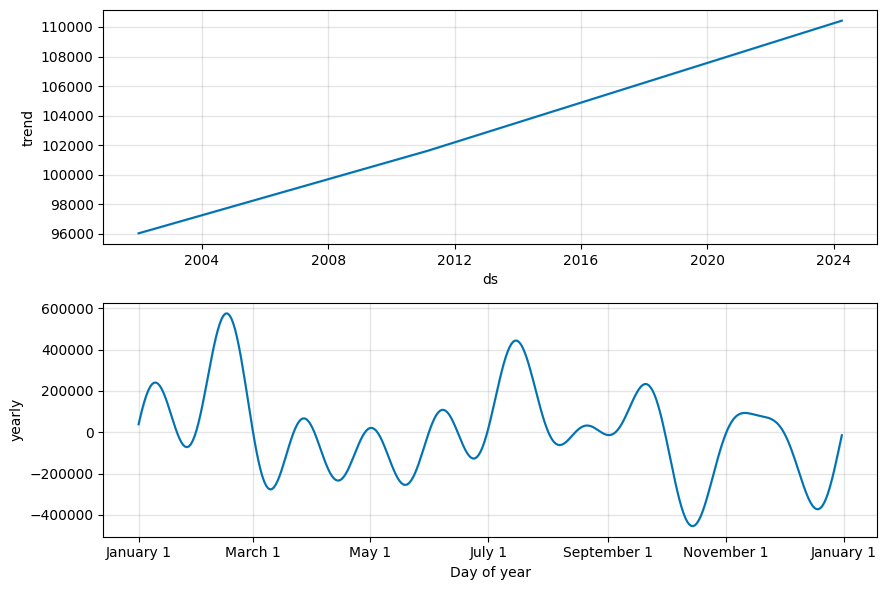

In [150]:
# Prophet Components Plot
model_prophet.plot_components(forecast_prophet)
plt.show()